##### Pytorch default implementation for CKA

In [1]:
import os 
import torch
from torch_cka import CKA
from utils.loaders import load_teacher_checkpoints 
from models.customresnets import CustomSlimResnet18
from avalanche.models import SlimResNet18
from torchsummary import summary
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR100
from avalanche.benchmarks import SplitCIFAR100
from torchvision import datasets, transforms
import importlib

In [2]:
def get_layer_list(model):
    layers_list=[]
    for name, module in model.named_children():
        if not name.startswith("params"):
            layers_list.append(name)
    return layers_list

In [3]:
path = os.path.join("runs", "splitcifar100_lwf_slimres18", "class_order_kept", "Student_epochs=800_lr=0.01_loss=mse_kd_rels=0.007_kd_scheduler=None_temp=2_cutmix_prob=0_mem_size=2000_sched_epochs=0", "Experience9.pt" )
os.path.exists(path)

True

In [4]:
student_model = CustomSlimResnet18(100)
student_checkpoint = torch.load(path)
student_model.load_state_dict(student_checkpoint["model_state_dict"])
teacher_model = SlimResNet18(100)
teacher_checkpoint = load_teacher_checkpoints("lwf_slimres18", 1, 10)
teacher_model.load_state_dict(teacher_checkpoint[-1])

<All keys matched successfully>

In [5]:
teacher_layers = get_layer_list(teacher_model)
student_layers = get_layer_list(student_model.slim_res18)
train_transform = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(
            (0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2762)
        ),
    ])
dataset = datasets.CIFAR100('./data/', train=True, download=True, transform=train_transform)

data = DataLoader(dataset, batch_size=128, shuffle=False)

Files already downloaded and verified


In [6]:
cka = CKA(model1 = student_model.slim_res18, model2 = teacher_model, model1_name="Student", model2_name="Teacher", device='cuda:1', model1_layers=teacher_layers[:-1], model2_layers=student_layers[:-1])
cka.compare(data)

/home/a.zuppolini/.conda/envs/teacher_model/lib/python3.8/site-packages/torch_cka/cka.py:153: UserWarning: Dataloader for Model 2 is not given. Using the same dataloader for both models.
  warn("Dataloader for Model 2 is not given. Using the same dataloader for both models.")
| Comparing features |: 100%|██████████| 391/391 [00:47<00:00,  8.27it/s]


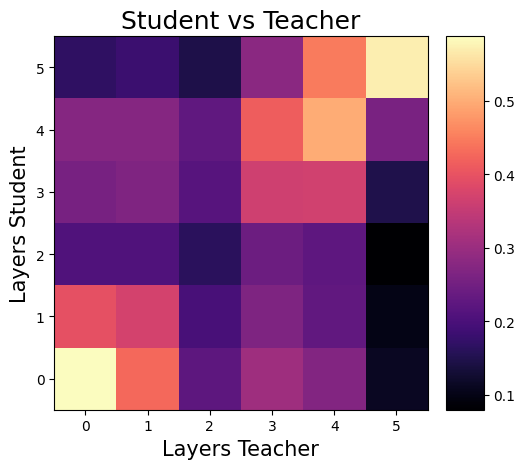

In [7]:
cka.plot_results()